In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 60

In [3]:
#utils.py is where all our custorm functions live is we set an autoreload on it.
%aimport utils 
from utils import fix_time, get_duration, get_action_usage, merge_action_usage

# The data

In [4]:
df_all = pd.read_excel('all data v3.xlsx', 'iLab data.txt', index_col=None, na_values=['NA'])

### Preparing a test sample
Let's first use a particular session as a test case. We extract only the data relevant to that case

In [5]:
#Using the example used for sketch.
#(df_all.condition1 == 'Savanna') & (df_all.student1 == 'penguin') & (df_all.student2 == 'gorilla')]
df_test = df_all[df_all['Session Id'] == 'L-2567b17a:120eda25685:-8000']

Next we filter out all actions with "INCORRECT" outcomes

In [6]:
before = df_test.shape[0]
df_test = df_test[df_test['Outcome'] == 'CORRECT']
print "We are left with {0} rows out of {1}".format(df_test.shape[0],before)

We are left with 212 rows out of 285


### We need to extract the time stamp of each action and it's duration

Next we fix the time logs and convert them to seconds. We also recalculate the time between actions now that we have gotten rid of incorrect actions.

In [7]:
time_start = list(df_test['time first action'])[0]
df_test['Time_seconds'] = df_test[['Time']].applymap(lambda current_time: fix_time(time_start,current_time))
df_test['Timeshifted'] = df_test[['Time']].shift(-1)
df_test['Duration'] = df_test[['Time','Timeshifted']].apply(get_duration, axis=1)

We create a column with the data for the contrasting cases

In [8]:
df_test['cases'] = df_test['CF(new1)'] +','+ df_test['CF(new2)']

### A first plot

In [9]:
def get_evaluation_steps_usage(df):
    submit_usage = get_action_usage(df,column_to_use["submit"],"submit")
    evaluation_usage = get_action_usage(df,column_to_use["evaluation"],"evaluation")
    checkIntuition_usage = get_action_usage(df,column_to_use["checkIntuition"],"checkIntuition")
    
    ##do some merging
    merged1 = merge_action_usage(submit_usage,evaluation_usage)
    merged2 = merge_action_usage(merged1, checkIntuition_usage)
    return merged2

In [10]:
color = {"Now try working on this new example":"#252525",
         "intuition": "#969696", # "#bdbdbd",
#          "submit": "#969696",
#          "evaluation": "#737373",
#          "checkIntuition": "#525252",
         'Median': "#33a02c",
         'Average': "#6a3d9a",
         'Sum': "#1f78b4",
         'all': "#ff7f00",
         'evaluation steps': "#525252",
        }
column_to_use = {"Now try working on this new example":"Feedback Text",
                 "intuition": "Selection",
                 "submit": "Selection",
                 "evaluation": "Selection",
                 "checkIntuition": "Selection",
                 'Median': 'Method_Recognized_1_Copied',
                 'Average': 'Method_Recognized_1_Copied',
                 'Sum': 'Method_Recognized_1_Copied',
                 'all': 'Method_Recognized_1_Copied',
                }

function_to_use = {"evaluation steps":get_evaluation_steps_usage}


# to_plot = ["intuition",'Median','Average','Sum','all',"submit","evaluation","checkIntuition","evaluation steps"]
to_plot = ["intuition",'Median','Average','Sum','all',"evaluation steps"]

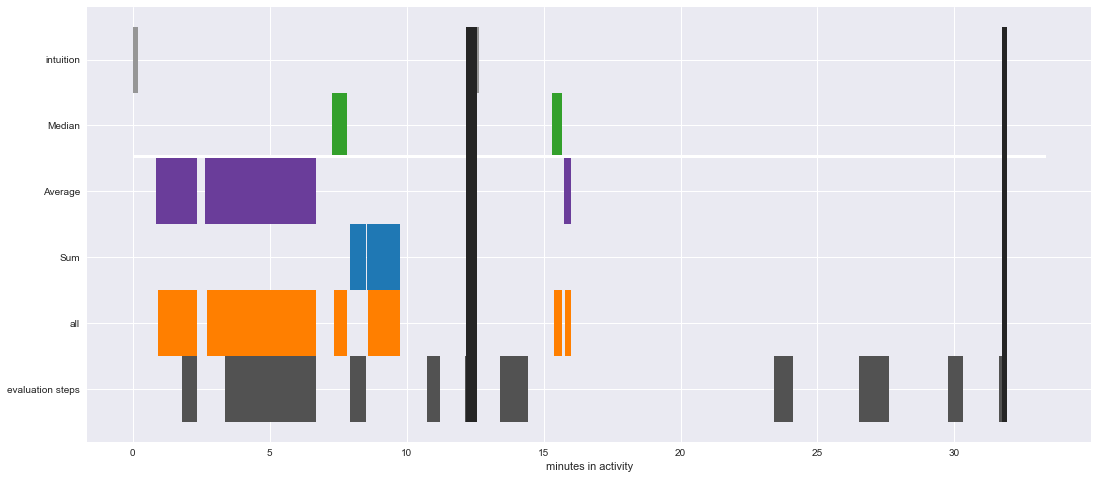

In [11]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot()
spacing =10
pos = 0
max_time = 0
actions = list(reversed(to_plot))
black = '#252525'
for i,action in enumerate(actions):
    if action in column_to_use.keys():
        action_use = get_action_usage(df_test,column_to_use[action],action)
    else:
        action_use = function_to_use[action](df_test)
    max_time = max(max_time,sum(action_use[-1]))
    ax.broken_barh(action_use,(pos,spacing),facecolors=color[action],alpha=1,linewidth=0)
    pos += spacing

#Add horizontal bar
ax.broken_barh([(0,ax.get_xlim()[1])],(40,0.5),facecolors='white',alpha=1,linewidth=0)

#Add new case bar
new_case = "Now try working on this new example"
action_use = get_action_usage(df_test,column_to_use[new_case],new_case)
max_time = max(max_time,sum(action_use[-1]))
ax.broken_barh(action_use,(0,len(actions)*spacing),facecolors=black,alpha=1,linewidth=0)

ax.set_xlabel('minutes in activity')
ax.set_xticks(range(0,int(max_time),60*5))
ax.set_xticklabels([str(x/60)+'' for x in range(0,int(max_time),60*5)])
ax.set_yticks(range(spacing/2,len(actions)*spacing,spacing))
ax.set_yticklabels(actions)
ax.grid(True)
plt.show()

The black vertical bar in the graph shows when a "new case" is presented

### Adding cases

In [12]:
def get_all_cases(df):
    '''Given a dataframe with students' activity, we extract all
    the contrasting cases they were given as well as starting time and
    length of time for which they were working on that case.
    
    Args:
        df (Pandas dataframe): The dataframe to search in.        

    Returns:
        coordinates: a dictionary where the keys are the cases and values are time coordinates.
                    Cases are in the format ('1 2 3 6','2 3 6 7').
                    Time coordinates are in the format (start_time, duration)
    '''
    coordinates = {}
    
    #get all possible cases
    raw_cases = list(set(df['cases']))
    for raw_case in raw_cases:
        #clean them up:
        case = tuple(str(data).replace('\"','') for data in raw_case.split(','))
        #we get time coordinates the way we always do
        coords = get_action_usage(df_test,'cases',raw_case)
        #we just need the start time and overall duration.
        coordinates[case] = coords
        #if it is possible that a pair of cases is used only once, then we can simplify with:
#         coordinates[case] = (coords[0][0],sum(coords[-1])-coords[0][0])
        
    return coordinates

#print get_all_cases(df_test)

### TODO
Ordered in some kind of general priority (in terms of need of feedback and desired feature)
* start implementing categories that are under “option 4” in the coding document (see copy below from May 29th)
* display method at "max", after a submit or delete all/reset
* add case data to graph
* display method at "max", after a submit or delete all/reset
* merge evaluation and checkintuition
* Indicate when current method could be used to “crack” or solve the contrasting cases. (‘when it works’) => correct order. 

### Overall graph structure:
Row 1: intuition
Rows 2-n: methods
Plot “build” events (any click in that part of the interface).
Below, show the method in writing.
Row n+1: Submit
Row n+2: Evaluation (merge Evaluate, Check Intuition).
Later consider merging “submit” into this. 
 
Plot building events, not durations 
Pauses become gaps. 



#### Categories
1. single value
* Central tendency , ready made
* Combination of ready made, random
* Range 6 - 1
* Count gaps (if numbers are 1 4 4 6)
    * click all empty points within range - 2 3 5
    * click all empty points within the largest gap - 2 3
* Extrapolated range
    * Inner range 4-4 - single step method
    * Any method that uses more than extreme values, and some form of subtraction. 
        * Recursive range (6-1) +/- (4-4)
        * All pairwise ranges (6-1, 6-4, 4-4, 4-1)
* extrapolated range + count all
* Canonical


### Adding "range" method